# Zone Vulnerability Analysis - Validation Notebook

This notebook validates the zone vulnerability timeseries dataset and visualization tools.

## Objectives
1. Load and explore the zone vulnerability dataset
2. Visualize zone grids for sample plays
3. Analyze zone evolution over time
4. Validate zone boundaries and metrics
5. Identify most/least vulnerable zones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our custom classes
from nfl_analysis import ZoneVulnerabilityVisualizer
from nfl_analysis import NFLDataConsolidator

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline

## 1. Load Zone Vulnerability Dataset

In [2]:
# Load the dataset
raw_dir = Path('../data/raw/114239_nfl_competition_files_published_analytics_final')
data_dir = Path('../data/consolidated')
zone_file = data_dir / 'zone_vulnerability_timeseries.parquet'

# consolidator = NFLDataConsolidator(raw_dir, data_dir)
# zone_vulnerability = consolidator.consolidate_all(skip_spatial=True)
# self.save_dataset(zone_vulnerability, 'zone_vulnerability_timeseries')

In [3]:
if not zone_file.exists():
    print(f"ERROR: Zone vulnerability dataset not found at {zone_file}")
    print("Please run the consolidation pipeline first.")
else:
    zone_data = pd.read_parquet(zone_file)
    print(f"✓ Loaded zone vulnerability dataset")
    print(f"  Shape: {zone_data.shape}")
    print(f"  Memory: {zone_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✓ Loaded zone vulnerability dataset
  Shape: (5953710, 24)
  Memory: 3003.9 MB


## 2. Dataset Overview

In [4]:
# Display first few rows
print("First 5 rows:")
zone_data.head()

First 5 rows:


,game_id,play_id,frame_id,week,zone_id,zone_depth_category,zone_lateral_category,zone_center_x,zone_center_y,zone_area,LOS_position,play_direction,phase,ball_land_x,ball_land_y,defender_count,defender_ids,nearest_defender_dist,coverage_density,zone_void_score,receiver_count,route_runner_count,receiver_ids,is_target_zone
0,2023090700,101,1,1,shallow_far_left,shallow,far_left,44.50,9.18,91.80,42,right,pre_snap,63.26,-0.22,1,52546,2.51,1.09,2.28,0,0,,False
1,2023090700,101,1,1,shallow_left_hash,shallow,left_hash,44.50,20.86,25.00,42,right,pre_snap,63.26,-0.22,0,,6.80,0.00,68.00,0,0,,False
2,2023090700,101,1,1,shallow_middle,shallow,middle,44.50,26.50,31.40,42,right,pre_snap,63.26,-0.22,1,53487,1.16,3.18,1.06,0,0,,False
3,2023090700,101,1,1,shallow_right_hash,shallow,right_hash,44.50,32.14,25.00,42,right,pre_snap,63.26,-0.22,0,,4.48,0.00,44.80,0,0,,False
4,2023090700,101,1,1,shallow_far_right,shallow,far_right,44.50,43.97,93.30,42,right,pre_snap,63.26,-0.22,1,54486,4.64,1.07,4.21,0,0,,False


In [5]:
# Column info
print("\nColumn Information:")
zone_data.info()


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953710 entries, 0 to 5953709
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   game_id                int64  
 1   play_id                int64  
 2   frame_id               int64  
 3   week                   int64  
 4   zone_id                object 
 5   zone_depth_category    object 
 6   zone_lateral_category  object 
 7   zone_center_x          float64
 8   zone_center_y          float64
 9   zone_area              float64
 10  LOS_position           int64  
 11  play_direction         object 
 12  phase                  object 
 13  ball_land_x            float64
 14  ball_land_y            float64
 15  defender_count         int64  
 16  defender_ids           object 
 17  nearest_defender_dist  float64
 18  coverage_density       float64
 19  zone_void_score        float64
 20  receiver_count         int64  
 21  route_runner_count     int64  
 2

In [6]:
# Summary statistics
print("\nSummary Statistics:")
zone_data[['defender_count', 'nearest_defender_dist', 'coverage_density', 
           'zone_void_score', 'receiver_count']].describe()


Summary Statistics:


,defender_count,nearest_defender_dist,coverage_density,zone_void_score,receiver_count
count,5953710.00,5953710.00,5953710.00,5953710.00,5953710.00
mean,0.44,7.72,0.68,62.18,0.15
std,0.61,5.06,1.26,60.70,0.41
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,3.79,0.00,4.17,0.00
50%,0.00,6.36,0.00,50.31,0.00
75%,1.00,10.84,1.07,107.04,0.00
max,5.00,50.00,16.00,500.00,4.00


## 3. Data Validation

In [7]:
# Check for expected 15 zones per frame
zones_per_frame = zone_data.groupby(['game_id', 'play_id', 'frame_id']).size()
print(f"Zones per frame - Min: {zones_per_frame.min()}, Max: {zones_per_frame.max()}")
print(f"Expected: 15 zones per frame")
if zones_per_frame.min() == 15 and zones_per_frame.max() == 15:
    print("✓ PASS: All frames have exactly 15 zones")
else:
    print("✗ FAIL: Some frames don't have 15 zones")
    print(zones_per_frame.value_counts())

Zones per frame - Min: 15, Max: 15
Expected: 15 zones per frame
✓ PASS: All frames have exactly 15 zones


In [8]:
# Check zone IDs
print("\nUnique zone IDs:")
print(sorted(zone_data['zone_id'].unique()))
print(f"\nTotal unique zones: {zone_data['zone_id'].nunique()}")
print("Expected: 15 zones (3 depths × 5 lateral positions)")


Unique zone IDs:
['deep_far_left', 'deep_far_right', 'deep_left_hash', 'deep_middle', 'deep_right_hash', 'intermediate_far_left', 'intermediate_far_right', 'intermediate_left_hash', 'intermediate_middle', 'intermediate_right_hash', 'shallow_far_left', 'shallow_far_right', 'shallow_left_hash', 'shallow_middle', 'shallow_right_hash']

Total unique zones: 15
Expected: 15 zones (3 depths × 5 lateral positions)


In [9]:
# Check phases
print("\nPhase distribution:")
print(zone_data['phase'].value_counts())
print("\nExpected phases: pre_snap, route_development, at_throw")


Phase distribution:
phase
route_development    5530470
pre_snap              211620
at_throw              211620
Name: count, dtype: int64

Expected phases: pre_snap, route_development, at_throw


## 4. Zone Analysis

Average Vulnerability Score by Zone:
zone_id
deep_far_left             147.12
deep_far_right            143.55
deep_left_hash            103.21
deep_right_hash           101.90
deep_middle                95.65
shallow_far_left           46.75
shallow_far_right          43.07
intermediate_far_left      32.87
shallow_left_hash          32.41
shallow_right_hash         32.37
intermediate_middle        32.12
shallow_middle             31.72
intermediate_right_hash    30.68
intermediate_left_hash     29.77
intermediate_far_right     29.46
Name: zone_void_score, dtype: float64


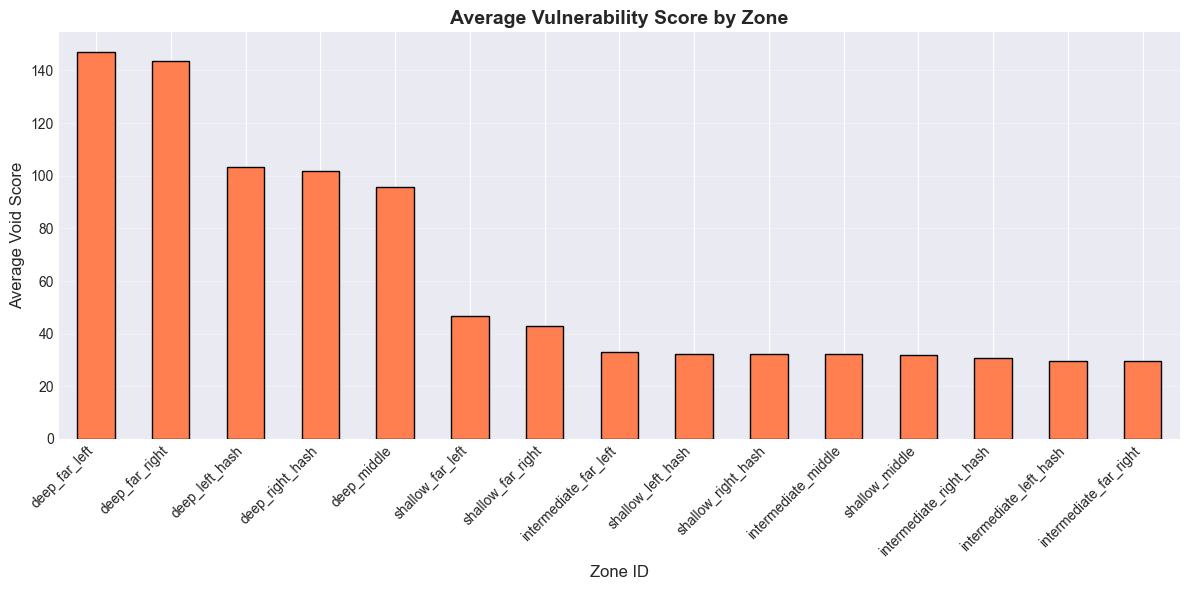

In [10]:
# Average vulnerability by zone
print("Average Vulnerability Score by Zone:")
avg_by_zone = zone_data.groupby('zone_id')['zone_void_score'].mean().sort_values(ascending=False)
print(avg_by_zone)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
avg_by_zone.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('Average Vulnerability Score by Zone', fontsize=14, fontweight='bold')
ax.set_xlabel('Zone ID', fontsize=12)
ax.set_ylabel('Average Void Score', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Average Defender Count by Zone:
zone_id
intermediate_far_right    0.95
intermediate_far_left     0.87
shallow_far_right         0.56
intermediate_left_hash    0.53
intermediate_middle       0.53
intermediate_right_hash   0.51
shallow_far_left          0.51
shallow_middle            0.50
shallow_right_hash        0.41
shallow_left_hash         0.41
deep_middle               0.22
deep_far_right            0.16
deep_right_hash           0.16
deep_left_hash            0.16
deep_far_left             0.15
Name: defender_count, dtype: float64


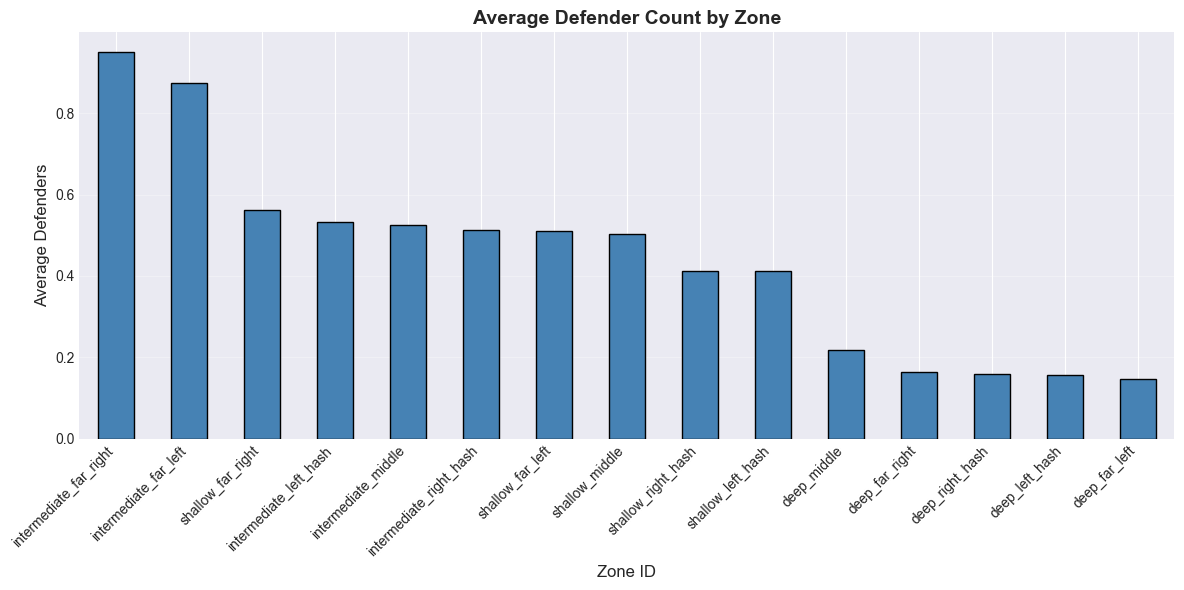

In [11]:
# Defender distribution by zone
print("\nAverage Defender Count by Zone:")
defenders_by_zone = zone_data.groupby('zone_id')['defender_count'].mean().sort_values(ascending=False)
print(defenders_by_zone)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
defenders_by_zone.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Average Defender Count by Zone', fontsize=14, fontweight='bold')
ax.set_xlabel('Zone ID', fontsize=12)
ax.set_ylabel('Average Defenders', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Target Zone Analysis

Target Zone Distribution:
zone_id
shallow_far_right          57974
shallow_far_left           55237
intermediate_far_right     44459
intermediate_far_left      44416
deep_far_right             35496
deep_far_left              35444
shallow_left_hash          23133
shallow_right_hash         20727
shallow_middle             18797
intermediate_middle        14951
intermediate_left_hash     14146
intermediate_right_hash    13314
deep_middle                 6521
deep_left_hash              6301
deep_right_hash             5998
dtype: int64


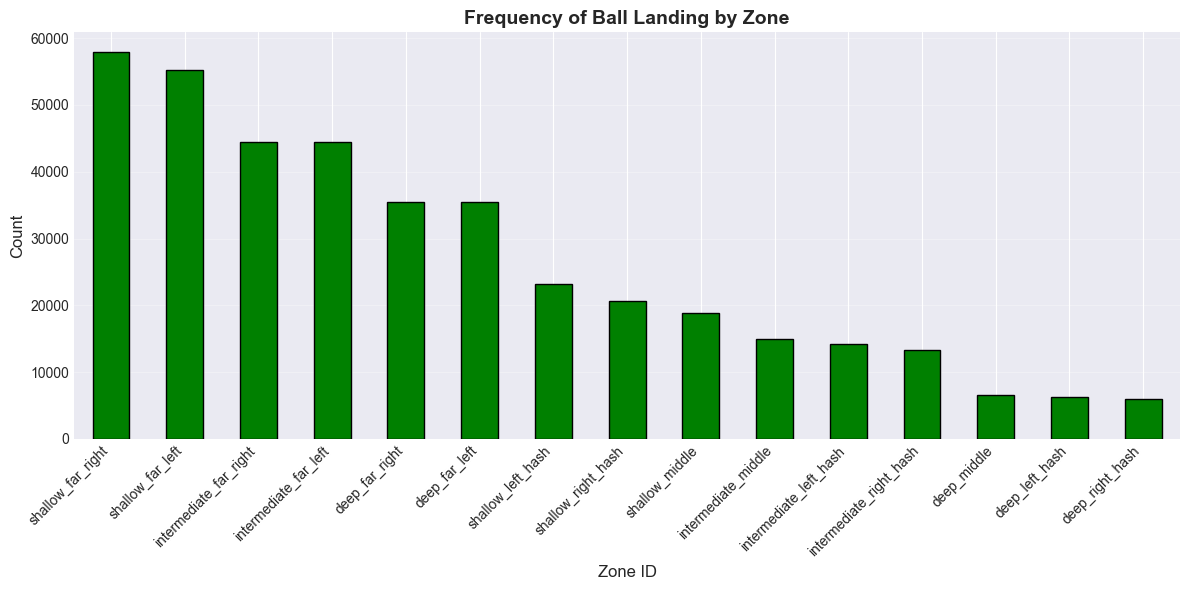

In [12]:
# Which zones are targeted most frequently?
target_zones = zone_data[zone_data['is_target_zone'] == True]

print("Target Zone Distribution:")
target_dist = target_zones.groupby('zone_id').size().sort_values(ascending=False)
print(target_dist)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
target_dist.plot(kind='bar', ax=ax, color='green', edgecolor='black')
ax.set_title('Frequency of Ball Landing by Zone', fontsize=14, fontweight='bold')
ax.set_xlabel('Zone ID', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Target Zone Vulnerability at Throw:
       zone_void_score  defender_count  nearest_defender_dist
count         14108.00        14108.00               14108.00
mean             49.91            0.53                   6.80
std              48.68            0.71                   3.80
min               0.03            0.00                   0.04
25%               4.13            0.00                   4.18
50%              47.24            0.00                   6.14
75%              77.49            1.00                   8.53
max             500.00            5.00                  50.00


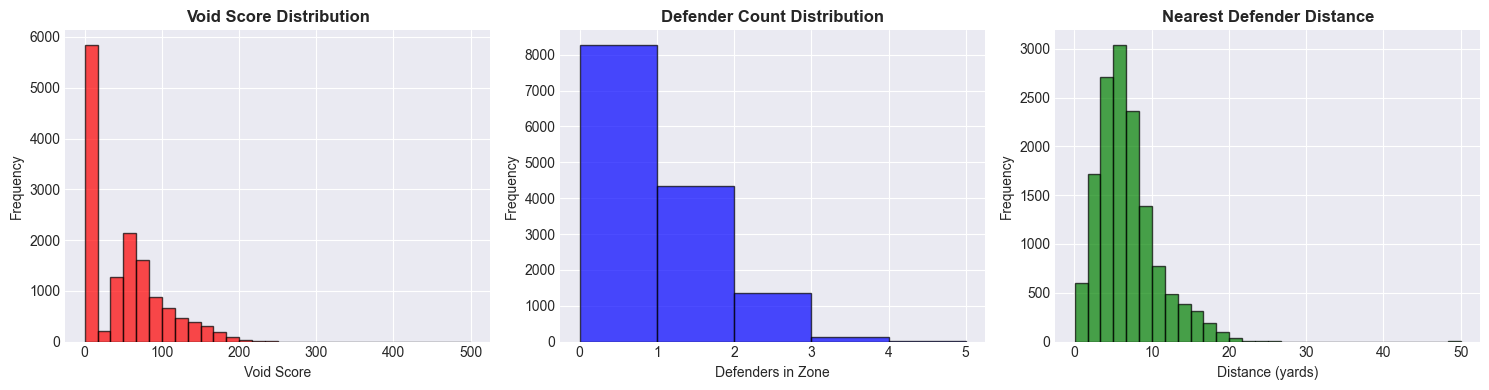

In [13]:
# Vulnerability of target zones at throw
target_at_throw = zone_data[
    (zone_data['is_target_zone'] == True) & 
    (zone_data['phase'] == 'at_throw')
]

print("\nTarget Zone Vulnerability at Throw:")
print(target_at_throw[['zone_void_score', 'defender_count', 'nearest_defender_dist']].describe())

# Histogram
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(target_at_throw['zone_void_score'], bins=30, color='red', edgecolor='black', alpha=0.7)
axes[0].set_title('Void Score Distribution', fontweight='bold')
axes[0].set_xlabel('Void Score')
axes[0].set_ylabel('Frequency')

axes[1].hist(target_at_throw['defender_count'], bins=range(6), color='blue', edgecolor='black', alpha=0.7)
axes[1].set_title('Defender Count Distribution', fontweight='bold')
axes[1].set_xlabel('Defenders in Zone')
axes[1].set_ylabel('Frequency')

axes[2].hist(target_at_throw['nearest_defender_dist'], bins=30, color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Nearest Defender Distance', fontweight='bold')
axes[2].set_xlabel('Distance (yards)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Zone Grid Visualization (Sample Plays)

In [14]:
# Initialize visualizer
visualizer = ZoneVulnerabilityVisualizer(data_dir='../data/consolidated')
visualizer.load_zone_data()

print("✓ Visualizer initialized and data loaded")

✓ Visualizer initialized and data loaded


In [15]:
# Get a sample play
sample_plays = zone_data[['game_id', 'play_id']].drop_duplicates().head(5)
print("Sample plays for visualization:")
print(sample_plays)

Sample plays for visualization:
         game_id  play_id
0     2023090700      101
390   2023090700      194
870   2023090700      219
1125  2023090700      361
1890  2023090700      436



Visualizing Game 2023090700, Play 101
Available frames: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)]


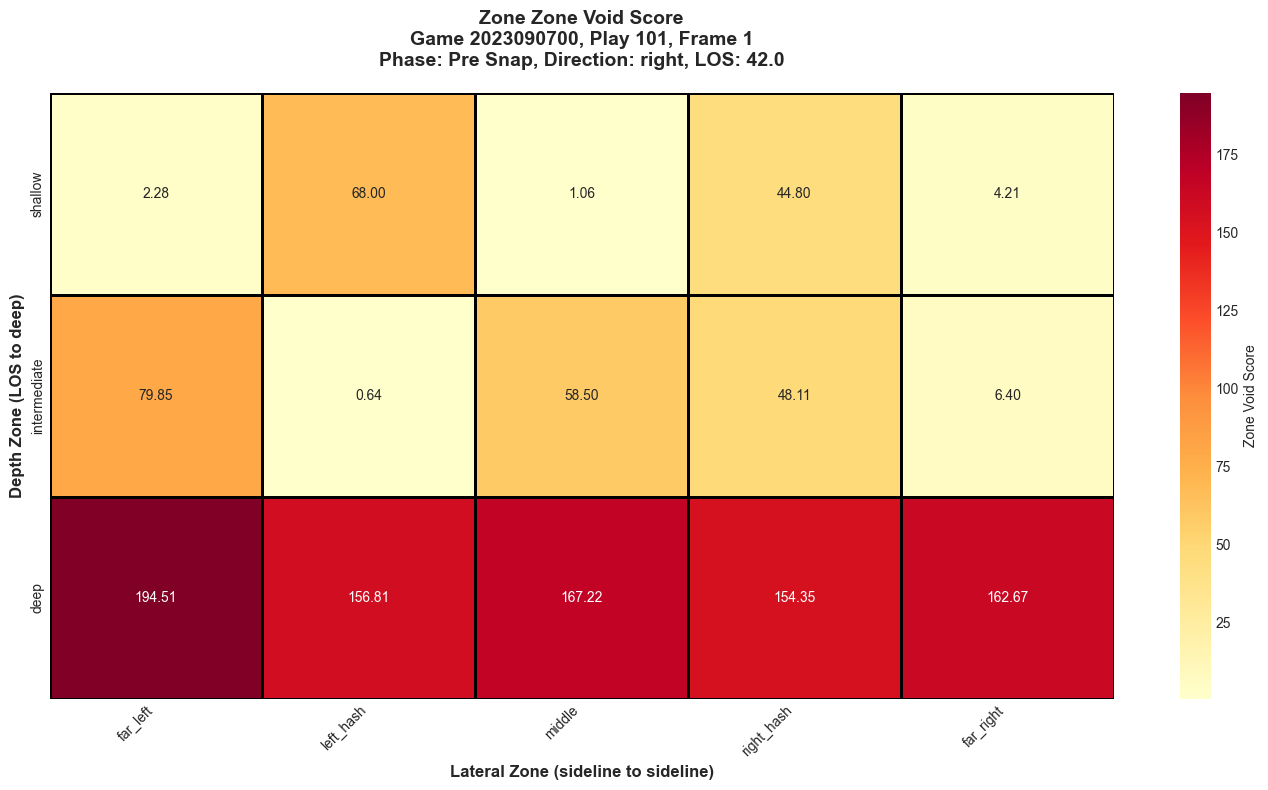

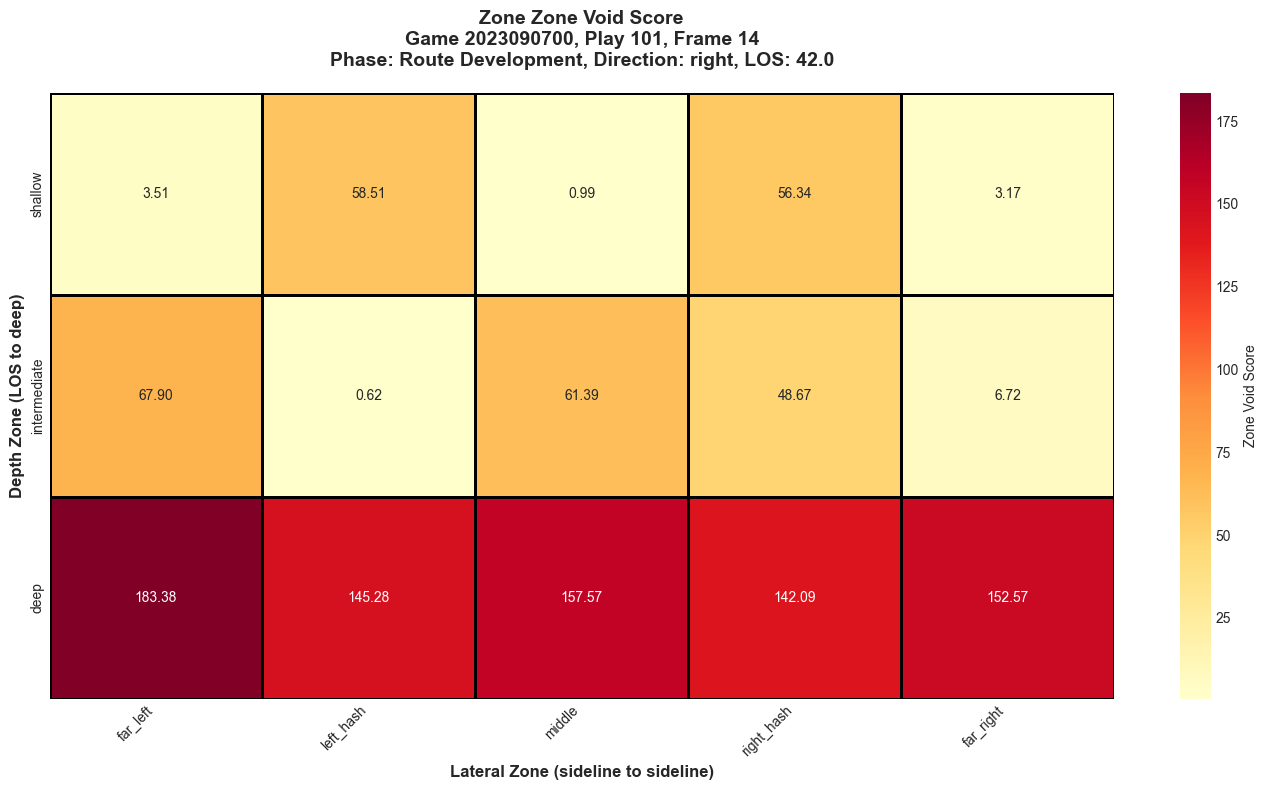

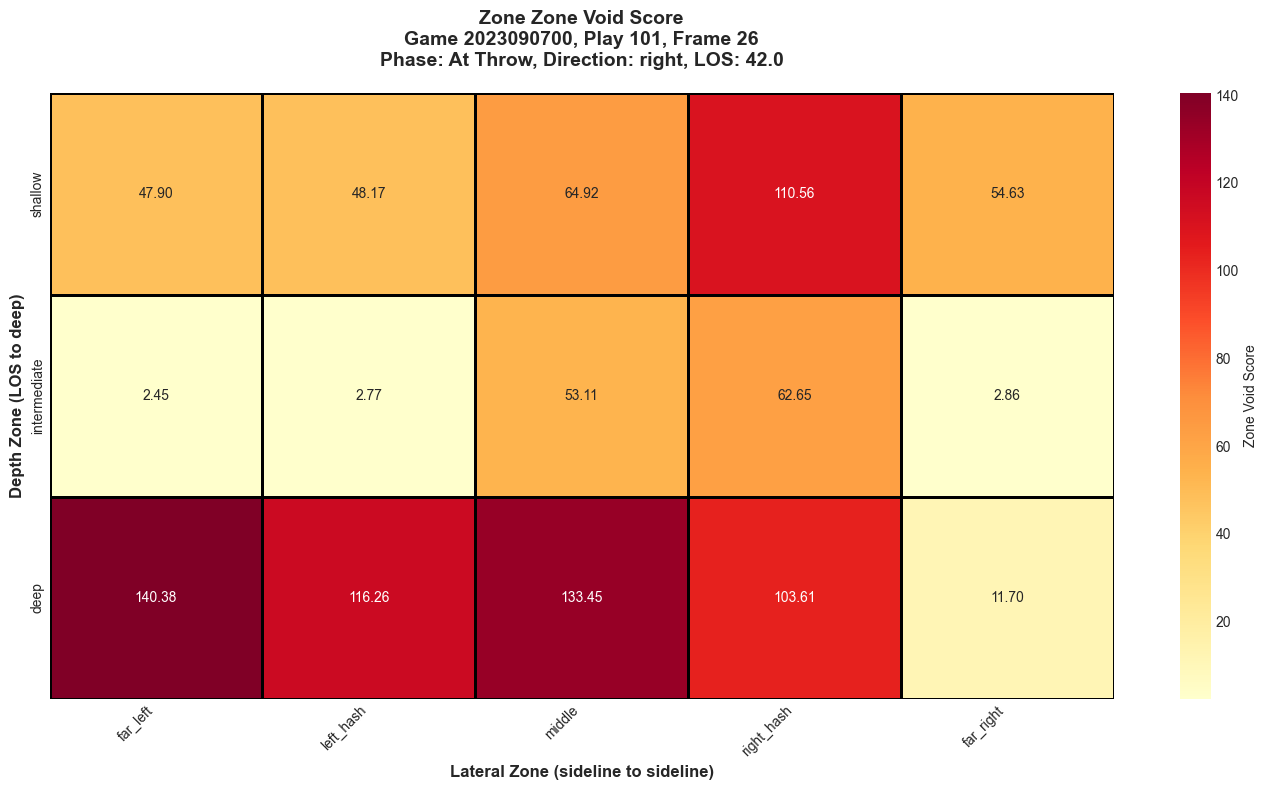

In [16]:
# Visualize zone grid for first sample play at different frames
game_id = sample_plays.iloc[0]['game_id']
play_id = sample_plays.iloc[0]['play_id']

# Get frames for this play
frames = zone_data[
    (zone_data['game_id'] == game_id) & 
    (zone_data['play_id'] == play_id)
]['frame_id'].unique()

print(f"\nVisualizing Game {game_id}, Play {play_id}")
print(f"Available frames: {sorted(frames)}")

# Visualize at pre-snap, mid-route, and at throw
for frame_id in [frames[0], frames[len(frames)//2], frames[-1]]:
    fig, ax = visualizer.plot_zone_grid(
        game_id=game_id,
        play_id=play_id,
        frame_id=frame_id,
        metric='zone_void_score',
        figsize=(14, 8)
    )
    plt.show()

## 7. Zone Evolution Over Time

Target zone for this play: deep_far_left


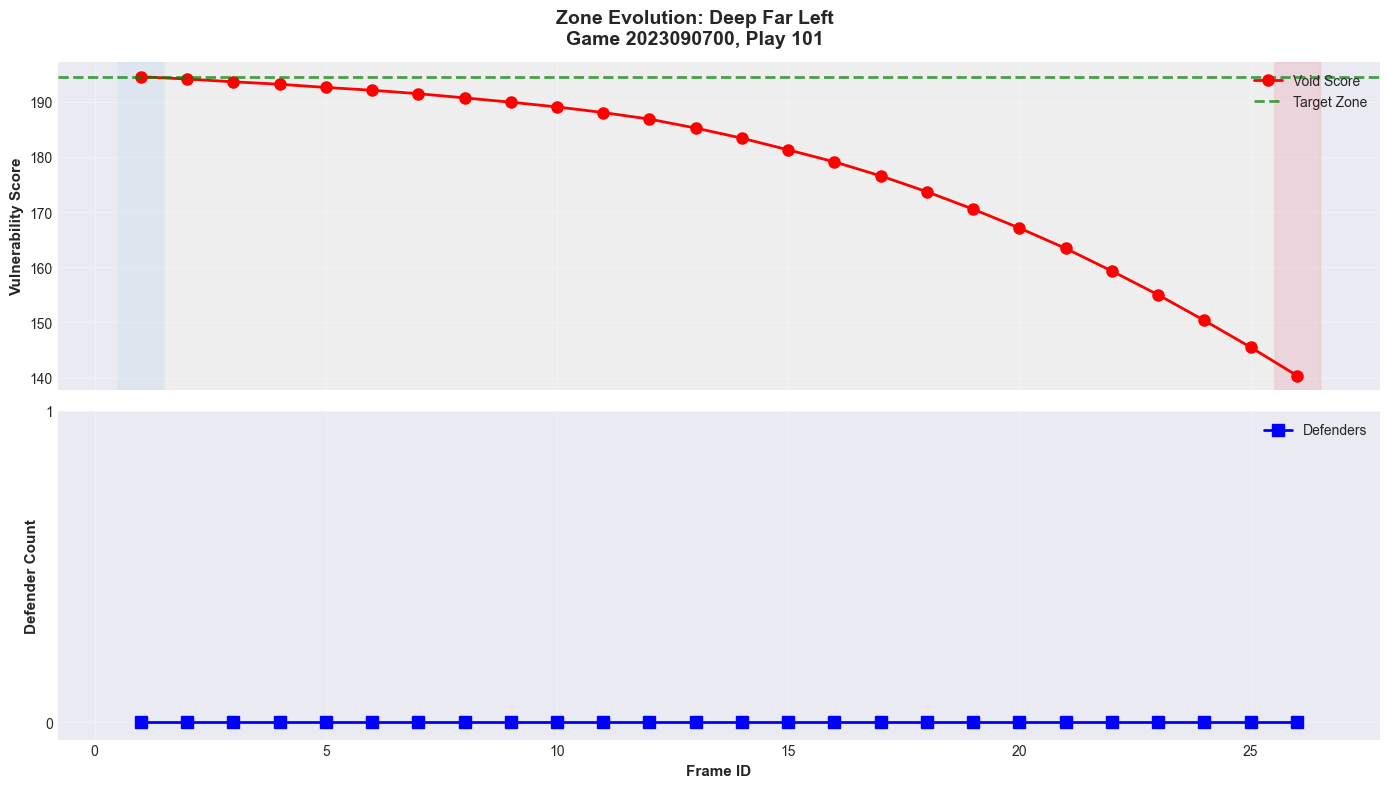

In [18]:
# Track evolution of a specific zone
game_id = sample_plays.iloc[0]['game_id']
play_id = sample_plays.iloc[0]['play_id']

# Find target zone for this play
target_zone = zone_data[
    (zone_data['game_id'] == game_id) & 
    (zone_data['play_id'] == play_id) &
    (zone_data['is_target_zone'] == True)
]['zone_id'].iloc[0]

print(f"Target zone for this play: {target_zone}")

# Visualize evolution
fig, axes = visualizer.plot_zone_evolution(
    game_id=game_id,
    play_id=play_id,
    zone_id=target_zone,
    figsize=(14, 8)
)
plt.show()
# zone_data[(zone_data['game_id'] == game_id) & (zone_data['play_id'] == play_id)]['is_target_zone']

## 8. Phase Analysis

In [19]:
# How does vulnerability change across phases?
phase_stats = zone_data.groupby('phase').agg({
    'zone_void_score': ['mean', 'std', 'min', 'max'],
    'defender_count': 'mean',
    'nearest_defender_dist': 'mean'
})

print("Vulnerability by Phase:")
print(phase_stats)

Vulnerability by Phase:
                  zone_void_score                   defender_count  \
                             mean   std  min    max           mean   
phase                                                                
at_throw                    57.40 54.02 0.02 500.00           0.44   
pre_snap                    67.89 66.75 0.01 500.00           0.44   
route_development           62.14 60.68 0.00 500.00           0.44   

                  nearest_defender_dist  
                                   mean  
phase                                    
at_throw                           7.28  
pre_snap                           8.18  
route_development                  7.72  


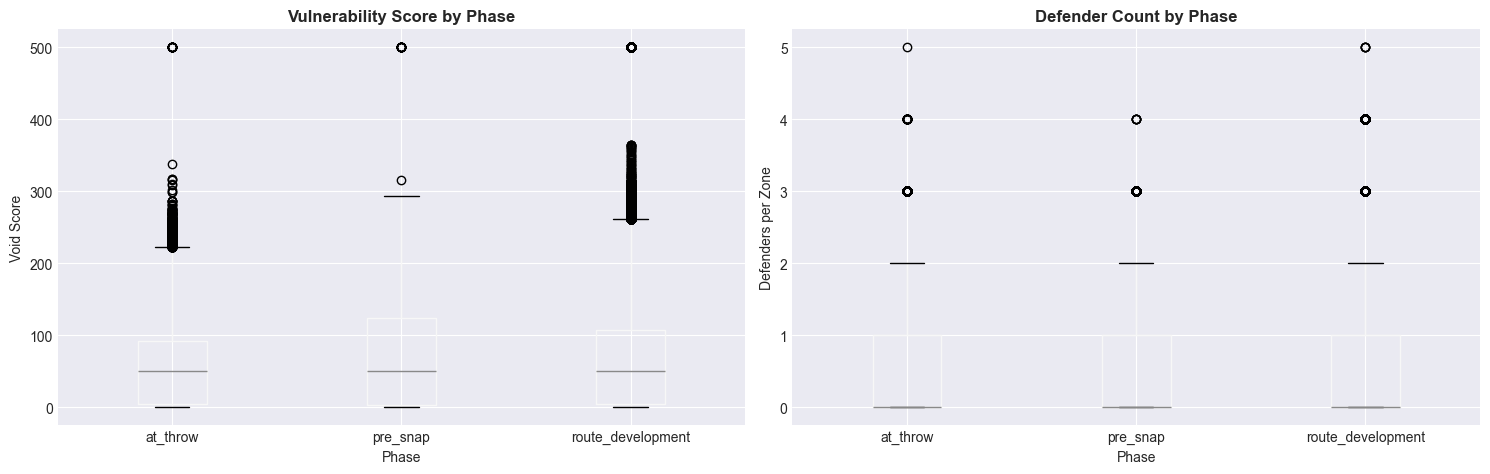

In [20]:
# Visualize phase progression
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

zone_data.boxplot(column='zone_void_score', by='phase', ax=axes[0])
axes[0].set_title('Vulnerability Score by Phase', fontweight='bold')
axes[0].set_xlabel('Phase')
axes[0].set_ylabel('Void Score')
plt.suptitle('')  # Remove default title

zone_data.boxplot(column='defender_count', by='phase', ax=axes[1])
axes[1].set_title('Defender Count by Phase', fontweight='bold')
axes[1].set_xlabel('Phase')
axes[1].set_ylabel('Defenders per Zone')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## 9. Summary and Validation Results

In [21]:
print("="*70)
print("ZONE VULNERABILITY DATASET VALIDATION SUMMARY")
print("="*70)
print(f"\nDataset Shape: {zone_data.shape}")
print(f"Total Plays: {zone_data[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"Total Frames: {zone_data[['game_id', 'play_id', 'frame_id']].drop_duplicates().shape[0]:,}")
print(f"Avg Frames/Play: {zone_data.groupby(['game_id', 'play_id'])['frame_id'].nunique().mean():.1f}")
print(f"\nZones per Frame: {zones_per_frame.mode()[0]}")
print(f"Unique Zones: {zone_data['zone_id'].nunique()}")
print(f"\nVulnerability Score Range: [{zone_data['zone_void_score'].min():.2f}, {zone_data['zone_void_score'].max():.2f}]")
print(f"Average Vulnerability: {zone_data['zone_void_score'].mean():.2f}")
print(f"\nMost Vulnerable Zone: {avg_by_zone.index[0]} (avg score: {avg_by_zone.iloc[0]:.2f})")
print(f"Least Vulnerable Zone: {avg_by_zone.index[-1]} (avg score: {avg_by_zone.iloc[-1]:.2f})")
print(f"\nMost Targeted Zone: {target_dist.index[0]} ({target_dist.iloc[0]:,} times)")
print("\n" + "="*70)
print("✓ VALIDATION COMPLETE")
print("="*70)

ZONE VULNERABILITY DATASET VALIDATION SUMMARY

Dataset Shape: (5953710, 24)
Total Plays: 14,108
Total Frames: 396,914
Avg Frames/Play: 28.1

Zones per Frame: 15
Unique Zones: 15

Vulnerability Score Range: [0.00, 500.00]
Average Vulnerability: 62.18

Most Vulnerable Zone: deep_far_left (avg score: 147.12)
Least Vulnerable Zone: intermediate_far_right (avg score: 29.46)

Most Targeted Zone: shallow_far_right (57,974 times)

✓ VALIDATION COMPLETE
